# 415-HW2
## Shuo Han

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import cosine_distances
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
import scipy
from transformers import BertTokenizer, BertModel
from sklearn.metrics.pairwise import cosine_similarity

2023-05-31 21:41:34.168268: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## EDA
### 1 Import and examine the data

In [2]:
rr = pd.read_excel('RestaurantReviews.xlsx', sheet_name='Reviews')
rs = pd.read_excel('RestaurantReviews.xlsx', sheet_name='Restaurants')

# identify duplicated columns
dc = rr.columns[rr.columns.duplicated()]
dcs = rs.columns[rs.columns.duplicated()]
print('Duplicated columns:', dc)
print('Duplicated columns:', dcs)

# columns with entirely missing data
mc = rr.columns[rr.isnull().all()]
mcs = rs.columns[rs.isnull().all()]
print('Missing columns:', mc)
print('Missing columns:', mcs)

# outliers in numerical variables with z-score
# rr
nc = rr.select_dtypes(include=[np.number]).columns

for col in nc:
    cz = col + '_zscore'
    rr[cz] = (rr[col] - rr[col].mean()) / rr[col].std(ddof=0)
outlier = rr[(rr.filter(regex='_zscore').gt(3) | rr.filter(regex='_zscore').lt(-3)).any(axis=1)]

numOut = len(outlier)
print("Number of outliers:", numOut)
numRR = len(rr)
print("Number of data:", numRR)
print("Percentage of outliers: ", numOut/numRR)
rr = rr.drop(outlier.index)
rr.drop(rr.filter(regex='_zscore').columns, axis=1, inplace=True)

# rs
ncs = rs.select_dtypes(include=[np.number]).columns

for col in ncs:
    cz = col + '_zscore'
    rs[cz] = (rs[col] - rs[col].mean()) / rs[col].std(ddof=0)
outliers = rs[(rs.filter(regex='_zscore').gt(3) | rs.filter(regex='_zscore').lt(-3)).any(axis=1)]

numOuts = len(outliers)
print("Number of outliers:", numOuts)
numRS = len(rs)
print("Number of data:", numRS)
print("Percentage of outliers: ", numOuts/numRS)
rs = rs.drop(outliers.index)
rs.drop(rs.filter(regex='_zscore$').columns, axis=1, inplace=True)

# rs data clean
rs['Longitude'] = rs['Longitude'].replace(',', '', regex=True).astype(float)

# Identify columns with missing values
print(rr.isnull().sum())
print(rs.isnull().sum())
print(rr.isnull().sum()/numRR)

rr['Vegetarian?'] = rr['Vegetarian?'].fillna('missing')
rr['Review Text'] = rr['Review Text'].fillna('')
rr['Weight (lb)'].fillna(rr['Weight (lb)'].mean(), inplace=True)
rr['Height (in)'].fillna(rr['Height (in)'].mean(), inplace=True)
rr.dropna(subset=['Birth Year', 'Marital Status', 'Has Children?','Average Amount Spent', 
                  'Preferred Mode of Transport', 'Northwestern Student?'], inplace=True)

merge = pd.merge(rr, rs, on='Restaurant Name', how='left')

Duplicated columns: Index([], dtype='object')
Duplicated columns: Index([], dtype='object')
Missing columns: Index([], dtype='object')
Missing columns: Index([], dtype='object')
Number of outliers: 8
Number of data: 1444
Percentage of outliers:  0.00554016620498615
Number of outliers: 3
Number of data: 63
Percentage of outliers:  0.047619047619047616
Reviewer Name                     0
Restaurant Name                   0
Rating                            0
Review Text                     546
Date of Review                    0
Birth Year                        2
Marital Status                   35
Has Children?                    38
Vegetarian?                    1342
Weight (lb)                      97
Height (in)                      54
Average Amount Spent              2
Preferred Mode of Transport       7
Northwestern Student?             1
dtype: int64
Restaurant Name      0
Cuisine              0
Latitude             0
Longitude            0
Average Cost         0
Open After 8pm?

In this part, I have identified duplicated columns and columns with entirely missing data in these two sheets but there is not one at all. Then I have identified outliers in these two sheets, and we can see that the percentage of outliers in the review sheet is 0.00554016620498615, and in the restaurant sheet 0.047619047619047616, which are both relatively small, so I have removed these from the dataset. Then I haved checked columns with missing values in these two sheets. There is not missing values in the restaurant sheet, but some in the review sheet. For the review sheet, I have calculated the portion of missing values in the sheet for each variable. The percentage of missing values in column "Vegetarian?" and "Review Text" are fairly large, so I replaced these with value "missing" for "Vegetarian?" and "" for "Review Text", since we are doing content analysis for that. Also, there are some columns with relatively less missing values, so I have replaced these columns 'Weight (lb)' and 'Height (in)' with the mean value of these columns. Also, there are some columns with very few missing value, even less than 3% of the data, 'Birth Year', 'Marital Status', 'Has Children?','Average Amount Spent', 'Preferred Mode of Transport', 'Northwestern Student?', so I have dropped these rows with missing values. And finally, I have added a mew dataset merge, which is merged by the review sheet and restaurant sheet.

### 2 histograms

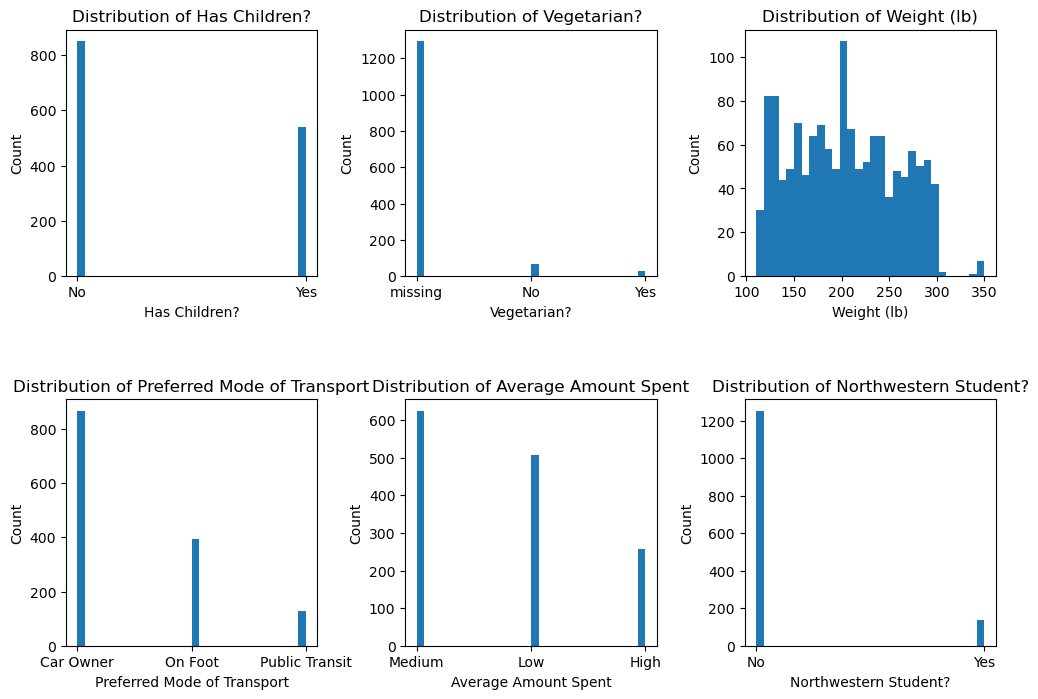

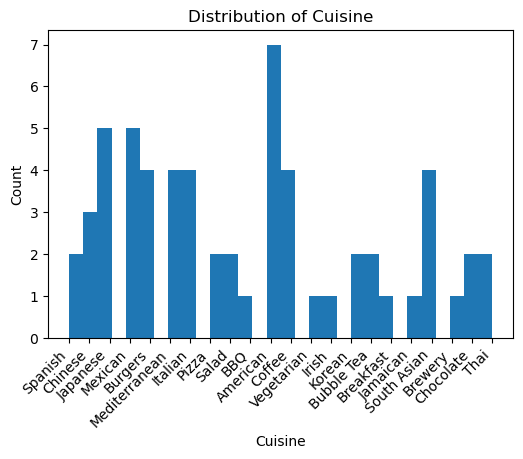

In [3]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
plt.subplots_adjust(hspace=0.5, wspace=0.35)

vrbs = ['Has Children?', 'Vegetarian?', 'Weight (lb)', 'Preferred Mode of Transport', 'Average Amount Spent', 'Northwestern Student?']
a = 0
b = 0
for i in vrbs:
    axes[a,b].hist(rr[i], bins=30)
    axes[a,b].set_title('Distribution of '+i)
    axes[a,b].set_xlabel(i)
    axes[a,b].set_ylabel('Count')
    if b == 2:
        b=0
        a+=1
    else:
        b+=1  

plt.figure(figsize=(6, 4))
plt.hist(rs['Cuisine'], bins=30)
plt.title('Distribution of Cuisine')
plt.xlabel('Cuisine')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Count')
plt.show()

I have tried to make histograms for 'has children', 'vegetarian', 'weight', 'prefered mode of transport', 'average amount spent', 'Northwestern student' and 'cusine'. We can see that the dataset is actually not properly balanced. 
In the histogram of 'Has Children?', we can see that the number of reviews from reviewers with children is almost double the number of reviews from reviewers without children, so it is really unbalanced. 
For the histogram of 'Vegetarian?', we can see that there are so many reviews from reviewers with unknown vegetarian preference, and there are more reviews from non-vegetarians than vegetarians, so the data is fairly incomplete in column 'Vegetarian?' and not so balanced with these data provide. 
For the the histogram of 'Weight (lb)', we can see that most of these reviews are from reviewers of weights between aroung 125lb to 220lb, and for these reviewers weighs fairly balanced between 110lb to 310lb, but there are some reviewers weighs aroung 350lb, and some especially more weighs around 210lb and 130lb.
In the histogram of 'Preferred Mode of Transport', there are more reviews are from car owners than reviewers who prefers on foot than public transit. Thus, from the aspect of 'Preferred Mode of Transport', we can still say the data is fairly unbalanced.
From the the histogram of 'Average Amount Spent', we can see that there are more reviews for restaurants of medium than low than hight average amount spent, and there are big differences in the amount of these reviews. Thus, the data is fairly unbalanced based on 'Average Amount Spent'.
From the the histogram of 'Northwestern Student?', we can see that there are much more reviews for restaurants from non-Northwestern Student than Northwestern Student, so the data is really unbalanced based on 'Northwestern Student?'.
From the the histogram of 'Cuisine', we can see that there are reviews for 22 types of cuisines, and there are many reviews for American cuisine, and only a few for BBQ, Vegetarian, Irish, Breakfase, Jamaican and Brewery cusine. There are great differences in the number, so the data is really unbalanced.

### 3 clustering on the user demographic data

In [4]:
# select categorical variables for one-hot encoding
cvars = ['Birth Year', 'Marital Status', 'Vegetarian?']
rc = rr[cvars]

# One-hot encode the categorical variables
enc = pd.get_dummies(rc)

# Perform clustering using KMeans algorithm
kmeans = KMeans(n_clusters=5, random_state=0).fit(enc)

# Add the cluster labels to the original dataframe
rr['cluster'] = kmeans.labels_

cluster_mean = rr.groupby('cluster')[cvars].mean()
cluster_count = rr['cluster'].value_counts().to_frame(name='Count')
cluster_summary = pd.concat([cluster_mean, cluster_count], axis=1)
print(cluster_summary)

    Birth Year  Count
0  1989.000000    326
1  1961.376344    279
2  1945.740541    185
3  1999.921569    357
4  1976.429167    240


/Users/ellenh/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/var/folders/6m/72gsx1kn1cd5rj99dq1_44yh0000gn/T/ipykernel_15932/1533792113.py:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cluster_mean = rr.groupby('cluster')[cvars].mean()


There are 5 clusters(after optimization) by KMeans algorithm, and we can see that the mean birth year of these groups are . The mean birth year of clusters ranges for 54 years, so these are really distinct 5 clusters of users. Also, we can see that there are roughly more users in the group of later mean birth year than the earlier.

### 4 compute the average review score across the entire cluster

In [5]:
# Compute the average review score for each cluster
avgs = rr.groupby('cluster')['Rating'].mean()

# Print the average review score for each cluster
cluster_rev = pd.concat([avgs, cluster_summary], axis=1)
print(cluster_rev)

     Rating   Birth Year  Count
0  3.726994  1989.000000    326
1  3.799283  1961.376344    279
2  3.627027  1945.740541    185
3  3.955182  1999.921569    357
4  3.733333  1976.429167    240


After computing the average review score across the entire cluster, we can see that there is a trend in these clusters that as the mean birth year of clusters get later, there are more users in the cluster and the mean rating tends to be higher in the cluster, but still some minor downward trends in the rating as years get later.

## Popularity matching
### 5

Most highly rated restaurant: 1062    Evanston Games & Cafe
Name: Restaurant Name, dtype: object
Average review score: 3.79
Median review score: 4.00


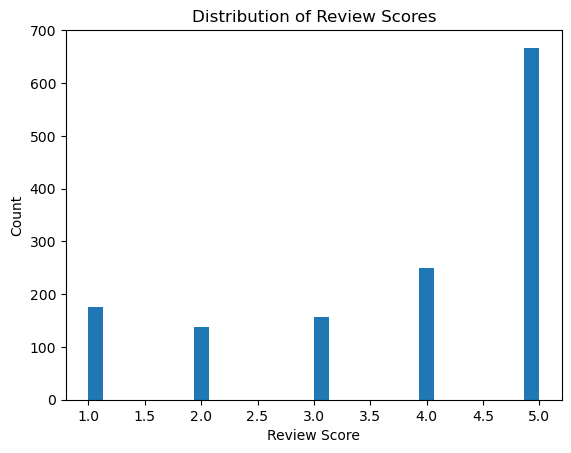

In [6]:
# the most highly rated restaurant
grouped_ratings = rr.groupby('Restaurant Name')['Rating'].mean()
maxr = grouped_ratings.idxmax()
hrr = rr.loc[rr['Restaurant Name'] == maxr, 'Restaurant Name']
print('Most highly rated restaurant: {}'.format(hrr))

# the average review score
avgrs = rr['Rating'].mean()
print('Average review score: {:.2f}'.format(avgrs))

# the median review score
medrs = rr['Rating'].median()
print('Median review score: {:.2f}'.format(medrs))

# histogram of review scores
plt.hist(rr['Rating'], bins=30)
plt.title('Distribution of Review Scores')
plt.xlabel('Review Score')
plt.ylabel('Count')
plt.show()

From the histogram of the review score, we can see that the number of reviews with a review score 5 is the most. And the rating are all of integer values ranging from 1 to 5 as shown above.

### 6

In [7]:
# restaurant with the largest quantity of reviews
maxr = rr['Restaurant Name'].value_counts().idxmax()
num_reviews = rr['Restaurant Name'].value_counts().max()

# restaurant with the median number of reviews
medr = rr['Restaurant Name'].value_counts().median()

# Print the results
print('Restaurant with the largest quantity of reviews: {} ({} reviews)'.format(maxr, num_reviews))
print('The median number of reviews received: {:.2f}'.format(medr))

Restaurant with the largest quantity of reviews: Campagnola (47 reviews)
The median number of reviews received: 23.00


### 7

In [8]:
# recommendation engine
def recommend(x):
    re_cui = merge[merge['Cuisine'] == x]
    rrat = re_cui.groupby('Restaurant Name')['Rating'].mean().reset_index(name='Mean Rating')
    sortr = rrat.sort_values(by='Mean Rating', ascending=False)
    recom = sortr['Restaurant Name'].tolist()
    print('These are recommended restaurants for', x, '(in descending order):', recom)

# give reccommendations for Spanish food, Chinese food, Mexican food, and Coffee
recommend('Spanish')
recommend('Chinese')
recommend('Mexican')
recommend('Coffee')

These are recommended restaurants for Spanish (in descending order): ['Tapas Barcelona', '5411 Empanadas']
These are recommended restaurants for Chinese (in descending order): ['Joy Yee Noodle', 'Peppercorns Kitchen', 'Lao Sze Chuan']
These are recommended restaurants for Mexican (in descending order): ['Fonda Cantina', 'Zentli', 'Taco Diablo', 'Fridas', 'Chipotle']
These are recommended restaurants for Coffee (in descending order): ['Evanston Games & Cafe', 'Philz Coffee', 'Brothers K Coffeehouse', 'Pâtisserie Coralie']


I have made the recommendation engine based on the mean vales of rating for each restaurant. A user can input a cusine type and receive a list of reccommendation in descending order based on popularity score.

### 8

Index(['Clare's Korner', 'Todoroki Sushi', 'Trattoria Demi', 'Rezas'], dtype='object', name='Restaurant Name')
Index(['Evanston Games & Cafe', 'La Principal', 'World Market', 'LeTour'], dtype='object', name='Restaurant Name')


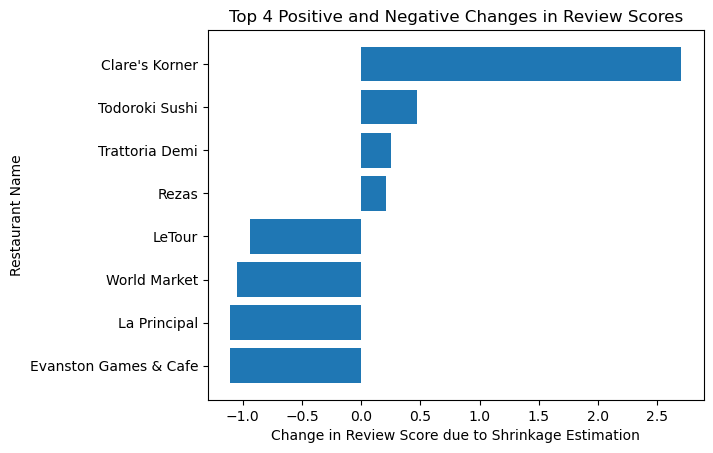

In [9]:
# Implement a shrinkage estimator that shrinks reviews back towards the mean score, scaled by the number of reviews a restaurant has received. 
shr_data = merge.groupby('Restaurant Name').agg({'Rating' : 'mean', 'Review Text': 'count'}).rename(columns={'Rating': 'Mean Rating', 'Review Text': 'Number of Ratings'})

mu_s = shr_data['Mean Rating'].mean()
N_mu = shr_data['Number of Ratings'].mean()

shr_est = []
for res in shr_data.index:
    N_p = shr_data.loc[res, 'Number of Ratings']
    alpha = min((N_p / N_mu), 1)
    mu_p = shr_data.loc[res,'Mean Rating']
    shr = (1 - alpha) * mu_s + alpha * mu_p
    shr_est.append(shr)

shr_data['Shrinkage Estimator'] = shr_est
shr_data['Rating Difference'] = shr_data['Shrinkage Estimator'] - shr_data['Mean Rating']

# restaurant benefits the most from this shrinkage estimation
top_pos = shr_data.nlargest(4, 'Rating Difference')
print(top_pos.index)
# restaurant hurt the most by this shrinkage estimation
top_neg = shr_data.nsmallest(4, 'Rating Difference')
print(top_neg.index)        

# Concatenate the dataframes for plotting
top_4 = pd.concat([top_neg, top_pos]).sort_values('Rating Difference')

# Create a bar chart
plt.barh(y=top_4.index, width=top_4['Rating Difference'])
plt.xlabel('Change in Review Score due to Shrinkage Estimation')
plt.ylabel('Restaurant Name')
plt.title('Top 4 Positive and Negative Changes in Review Scores')
plt.show()

I have implement a shrinkage estimator that shrinks reviews back towards the mean score, scaled by the number of reviews a restaurant has received from lecture slides right here. Top 4 restaurants that benefits the most from this shrinkage estimation are 'Clare's Korner', 'Todoroki Sushi', 'Trattoria Demi', 'Rezas'; top 4 restaurants hurt the most by it are 'Evanston Games & Cafe', 'La Principal', 'World Market', 'LeTour'. Also, I have made a plot that demonstrates changes in review scores due to shrinkage estimation for the top 4-positive and negative changes in a bar chart. We can see from the plot above that the restaurant 'Clare's Korner' is affected the most after shrinking and its rating is improved by this, while other restaurants does not seriously benefit from this. Also, there are more restaurant fairly negtively affected by shrinking, and they are affected a lot.

## Content based filtering
### 9

In [10]:
# One-hot encode the categorical variables
cat_cols = ['Cuisine', 'Open After 8pm?', 'Brief Description']

enc = OneHotEncoder(sparse=False)
enc_data = pd.DataFrame(enc.fit_transform(rs[cat_cols]), columns=enc.get_feature_names_out(cat_cols))

# Combine the one-hot encodeddata with the original data
all_data = pd.concat([rs.drop(columns=cat_cols).reset_index(drop=True), enc_data.reset_index(drop=True)], axis=1)

# Set the restaurant name as index
all_data.set_index('Restaurant Name', inplace=True)

# Compute the Euclidean distance matrix between all data points
distance_matrix = euclidean_distances(all_data)
print(distance_matrix)

# Add the restaurant name back to the distance matrix
distance_matrix = pd.DataFrame(distance_matrix, index=all_data.index, columns=all_data.index)

[[0.         2.00000079 7.141429   ... 2.45007571 2.44963616 7.28011246]
 [2.00000079 0.         7.28011037 ... 2.45008167 2.44962076 7.28011211]
 [7.141429   7.28011037 0.         ... 7.41637534 7.41623844 2.00000267]
 ...
 [2.45007571 2.45008167 7.41637534 ... 0.         2.00057594 7.41635632]
 [2.44963616 2.44962076 7.41623844 ... 2.00057594 0.         7.41623089]
 [7.28011246 7.28011211 2.00000267 ... 7.41635632 7.41623089 0.        ]]


/Users/ellenh/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


There are 4 columns of categorical variables in the sheet restaurants, so I have used one-hot encodings to deal with these 4 columns. And then I have computed the euclidean distance between every restaurant and printed the distance matrix above, but it takes spaces to display with restaurant names so I have formed one in code but display the one without restaurant name here.

### 10

In [11]:
# cosine distance
distance_matrix_cos = cosine_distances(all_data)
print(distance_matrix_cos)
distance_matrix_cos = pd.DataFrame(distance_matrix_cos, index=all_data.index, columns=all_data.index)

[[0.         0.00020287 0.00254742 ... 0.00030428 0.00030423 0.00265035]
 [0.00020287 0.         0.0026499  ... 0.00030428 0.00030423 0.00265018]
 [0.00254742 0.0026499  0.         ... 0.00274755 0.00274898 0.00020772]
 ...
 [0.00030428 0.00030428 0.00274755 ... 0.         0.00020286 0.00274782]
 [0.00030423 0.00030423 0.00274898 ... 0.00020286 0.         0.00274926]
 [0.00265035 0.00265018 0.00020772 ... 0.00274782 0.00274926 0.        ]]


Silimar to the process above, this time I have computed the cosine distance between every restaurant and printed the distance matrix above, but it takes spaces to display with restaurant names so I have formed one in code but display the one without restaurant name here.

### 11

['Leonidas Cafe Chocolaterie', "Hecky's BBQ", 'Le Peep', "Kilwin's", 'Clarkes Off Campus']


/var/folders/6m/72gsx1kn1cd5rj99dq1_44yh0000gn/T/ipykernel_15932/1192043847.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=20)


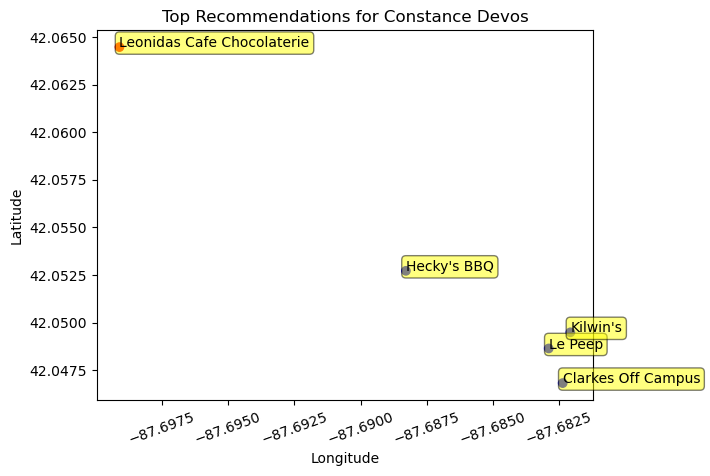

In [46]:
# a script that takes a user and returns a reccommendation using content based filtering
# Define a function to get the top recommendations for a user
def get_reco(user):
    liked_restaurants = rr.loc[rr["Reviewer Name"] == user]["Restaurant Name"].tolist()
    avg_distances = distance_matrix_cos.loc[liked_restaurants].mean()
    top_recom = avg_distances.sort_values().index.tolist()[:5]
    print(top_recom)
    
# Example usage
top_recom = get_reco('Constance Devos')

# Plot the recommended restaurants by their latitude and longitude
top_recom = ['Leonidas Cafe Chocolaterie', "Hecky's BBQ", 'Le Peep', "Kilwin's", 'Clarkes Off Campus']
recom_data = rs.loc[rs['Restaurant Name'].isin([r for r in top_recom if r is not None])]

fig, ax = plt.subplots()
colors = np.where(recom_data['Restaurant Name'] == 'Leonidas Cafe Chocolaterie', 'red', 'blue')
ax.scatter(recom_data['Longitude'], recom_data['Latitude'], c=colors)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Top Recommendations for Constance Devos')
ax.set_xticklabels(ax.get_xticklabels(), rotation=20)

for i, row in recom_data.iterrows():
    if row['Restaurant Name'] in top_recom:
        ax.annotate(row['Restaurant Name'], (row['Longitude'], row['Latitude']), bbox=dict(boxstyle='round,pad=0.3', fc='yellow', alpha=0.5))

plt.show()

I have written a function that takes a user and returns a reccommendation using content based filtering based on cosine distance above. And tried to find the recommended restaurants for the user 'Constance Devos', and get the list of recommended restaurant 'Leonidas Cafe Chocolaterie', "Hecky's BBQ", 'Le Peep', "Kilwin's", 'Clarkes Off Campus'. Also for Constance Devos, I have plotted the top reccommendations by the system. 

## Natural language analysis
### 12

In [13]:
# Augement brief description
rs['Augmented Description'] = rs['Brief Description'] + rs['Cuisine']

I have augemented this description by attaching the restaurant's cusine type to the end of the description as a column 'Augmented Description'.

### 13

In [14]:
# Compute the Jaccard matrix
jaccard_matrix = rs['Augmented Description'].apply(lambda x: set(x.split())).apply(lambda x: rs['Augmented Description'].apply(lambda y: len(x.intersection(set(y.split()))))/rs['Augmented Description'].apply(lambda z: len(set(z.split())))).values.reshape(rs.shape[0], rs.shape[0])
print(jaccard_matrix)
# Create a DataFrame from the matrix with restaurant names as row and column labels
jaccard_df = pd.DataFrame(jaccard_matrix, index=rs['Restaurant Name'], columns=rs['Restaurant Name'])

[[1.         0.1        0.14285714 ... 0.21428571 0.125      0.25      ]
 [0.125      1.         0.21428571 ... 0.14285714 0.1875     0.25      ]
 [0.125      0.15       1.         ... 0.07142857 0.3125     0.125     ]
 ...
 [0.1875     0.1        0.07142857 ... 1.         0.0625     0.5       ]
 [0.125      0.15       0.35714286 ... 0.07142857 1.         0.125     ]
 [0.125      0.1        0.07142857 ... 0.28571429 0.0625     1.        ]]


The computed Jaccard matrix using the elements of Augemented Description is shown above, but same as before, it takes spaces to display with restaurant names so I have formed one in code but display the one without restaurant name here.

### 14

In [15]:
#  compute the TF-IDF score for each restaurant's Augmented Description
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(rs['Augmented Description'])

def tfi_res(word): 
    word_scores = tfidf_matrix[:, tfidf.vocabulary_[word]].toarray()

    highest_word_score_index = np.argmax(word_scores)
    restaurant_name = rs.iloc[highest_word_score_index]['Restaurant Name']
    print('The restaurant with the highest TF-IDF score for the word', word, 'is:', restaurant_name)

tfi_res('cozy')
tfi_res('chinese')

The restaurant with the highest TF-IDF score for the word cozy is: Taste of Nepal
The restaurant with the highest TF-IDF score for the word chinese is: Lao Sze Chuan


I have compute the TF-IDF score for each restaurant's Augmented Description above first and made a function for that. By this function, we can see that the restaurant with the highest TF-IDF score for the word 'cozy' is Taste of Nepal, for 'chinese' is Lao Sze Chuan.

### 15

In [16]:
# get the 100 most popular words in the Augmented Description column
tfidf1 = TfidfVectorizer(max_features=100)
tfidf1.fit(rs['Augmented Description'])
feature_names = tfidf1.get_feature_names_out()
top_words = sorted(zip(tfidf1.idf_, feature_names))[:100]
top_words = [word[1] for word in top_words]
print(top_words)

# create 64 TF-IDF vectors of length 100, one for each restaurant
# create a copy of the rs dataframe and reset its index
rs_copy = rs.copy().reset_index(drop=True)

# create 64 TF-IDF vectors of length 100, one for each restaurant
tfidf_vectors = []
for i, desc in enumerate(rs_copy['Augmented Description']):
    tfidf_scores = {}
    for word in top_words:
        tfidf_score = tfidf_matrix[i, tfidf1.vocabulary_[word]]
        tfidf_scores[word] = tfidf_score
    tfidf_vectors.append([rs_copy.loc[i, 'Restaurant Name']] + list(tfidf_scores.values()))

df_tfidf_vectors = pd.DataFrame(tfidf_vectors, columns=['Restaurant Name'] + top_words)
print(df_tfidf_vectors.head(3))


['known', 'for', 'in', 'and', 'with', 'chain', 'plus', 'space', 'american', 'restaurant', 'setting', 'coffee', 'fare', 'food', 'italian', 'of', 'burgers', 'warm', 'asian', 'bowls', 'casual', 'dishes', 'eatery', 'including', 'lunch', 'mexican', 'served', 'small', 'traditional', 'an', 'cafe', 'chinese', 'classic', 'drinks', 'japanese', 'local', 'mediterranean', 'other', 'south', 'vegetarian', 'bar', 'beers', 'breakfast', 'bright', 'byob', 'cocktails', 'contemporary', 'cozy', 'cuisine', 'extensive', 'fries', 'is', 'joint', 'korean', 'laid', 'meats', 'menu', 'or', 'outpost', 'pizza', 'pizzas', 'popular', 'quaint', 'sandwiches', 'simple', 'stylish', 'sushi', 'tacos', 'to', 'wood', 'bubble', 'chocolate', 'french', 'fresh', 'goods', 'grub', 'hot', 'ingredients', 'intimate', 'it', 'plates', 'prepared', 'ramen', 'relaxed', 'spanish', 'spot', 'storefront', 'such', 'takeout', 'tea', 'thai', 'the', 'upscale', 'whimsical', 'wine', 'your', 'indian', 'irish', 'jamaican', 'vegan']
   Restaurant Name  

The list of the 100 most popular words in the Augmented Description column is shown above, and the computed TF-IDF score for that word as a 64 TF-IDF vectors of length 100, one for each restaurant is also formed, and I have displayed the first 3 restaurant above.

### 16

In [17]:
# compute the TF-IDF distance matrix
tfidf_dist_matrix = cosine_distances(tfidf_matrix)

# create a dataframe with the cosine distances and restaurant names as index and columns
df_tfidf_dist_matrix = pd.DataFrame(tfidf_dist_matrix, index=rs_copy['Restaurant Name'], columns=rs_copy['Restaurant Name'])

# print the dataframe
print(df_tfidf_dist_matrix.head(3))

Restaurant Name  Tapas Barcelona  Lao Sze Chuan  5411 Empanadas  \
Restaurant Name                                                   
Tapas Barcelona         0.000000       0.840362        0.834028   
Lao Sze Chuan           0.840362       0.000000        0.975756   
5411 Empanadas          0.834028       0.975756        0.000000   

Restaurant Name  Hokkaido Ramen  Tomo Japanese Street Food  \
Restaurant Name                                              
Tapas Barcelona        0.988324                   0.964442   
Lao Sze Chuan          0.989275                   0.991437   
5411 Empanadas         0.986613                   0.989311   

Restaurant Name  Kuni's Japanese Restaurant   Kansaku  Taco Diablo   Fridas  \
Restaurant Name                                                               
Tapas Barcelona                    0.830653  0.957596     0.988848  1.00000   
Lao Sze Chuan                      0.886685  0.946900     0.989757  1.00000   
5411 Empanadas                     0.

The first 3 rows of the TF-IDF distance matrix with the distance between the TF-IDF vectors for restaurants is shown above.

### 17

In [18]:
# Load pre-trained BERT model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

# Define function to embed restaurant description using BERT
def embed_bert(text):
    inputs = tokenizer.encode_plus(text, add_special_tokens=True, return_tensors='pt')
    outputs = bert_model(inputs['input_ids'], attention_mask=inputs['attention_mask'])[1]
    return outputs.detach().numpy()

# Embed all restaurant descriptions
res_des = rs["Augmented Description"].tolist()
res_names = rs["Restaurant Name"].tolist()
res_emb = np.array([embed_bert(d) for d in res_des])

# Compute Embedding-Distance matrix
embedding_matrix = cosine_distances(res_emb.reshape(len(res_emb), -1))
embedding_df = pd.DataFrame(embedding_matrix, columns=res_names, index=res_names)
print(embedding_df.head(3))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


                 Tapas Barcelona  Lao Sze Chuan  5411 Empanadas  \
Tapas Barcelona         0.000000       0.015169        0.013951   
Lao Sze Chuan           0.015169       0.000000        0.012449   
5411 Empanadas          0.013951       0.012449        0.000000   

                 Hokkaido Ramen  Tomo Japanese Street Food  \
Tapas Barcelona        0.018831                   0.014805   
Lao Sze Chuan          0.011399                   0.014912   
5411 Empanadas         0.015158                   0.007110   

                 Kuni's Japanese Restaurant   Kansaku  Taco Diablo    Fridas  \
Tapas Barcelona                    0.023336  0.015831     0.011077  0.007787   
Lao Sze Chuan                      0.010407  0.012575     0.012718  0.013042   
5411 Empanadas                     0.023593  0.003776     0.003483  0.008620   

                 Edzo's Burger Shop  ...  Pâtisserie Coralie  \
Tapas Barcelona            0.008817  ...            0.011240   
Lao Sze Chuan              0.0129

The first 3 rows of the Embedding-Distance matrix with the distance between embedding vectors of restaurants is shown above.

### 18

In [19]:
# 13 Jaccard
sort = jaccard_df.loc['Lao Sze Chuan'].sort_values(ascending=False)
krec = sort[sort > sort.mean()]
krec_rate = rr[rr['Restaurant Name'].isin(krec.index)]
res_rate = krec_rate.groupby('Restaurant Name')['Rating'].mean()
print('Jaccard:', res_rate.mean())

# 16 TF-IDF
sort = df_tfidf_dist_matrix.loc['Lao Sze Chuan'].sort_values(ascending=False)
krec = sort[sort > sort.mean()]
krec_rate = rr[rr['Restaurant Name'].isin(krec.index)]
res_rate = krec_rate.groupby('Restaurant Name')['Rating'].mean()
print('TF-IDF:', res_rate.mean())

# 17 Embedding-Distance
sort = embedding_df.loc['Lao Sze Chuan'].sort_values(ascending=False)
krec = sort[sort > sort.mean()]
krec_rate = rr[rr['Restaurant Name'].isin(krec.index)]
res_rate = krec_rate.groupby('Restaurant Name')['Rating'].mean()
print('Embedding-Distance:', res_rate.mean())

Jaccard: 3.9656301851894824
TF-IDF: 3.819726211811076
Embedding-Distance: 3.8577545115602216


Based on matrices from question 13, 16, 17, I have tried to do k recommendations as the method mentioned in the lecture notes for restaurant 'Lao Sze Chuan' based on these matrices. Since the mean rating are all assigned as a value of 1 as they are greater than 3, I calculated the actual values without bounded here, and we can see that these mean scores are so close, so it is really hard to tell which one is better, but Jaccard is a little better than TF-IDF and Embedding-Distance for recommendation here.

## Collaborative Filtering
### 19

In [20]:
# Extract the numeric columns
cols = ['Reviewer Name', 'Has Children?', 'Vegetarian?', 'Weight (lb)', 'Preferred Mode of Transport', 'Average Amount Spent', 'Northwestern Student?']
rr_numeric = rr[cols]

# Create a new DataFrame with unique reviewers
features = rr_numeric.drop_duplicates(subset=['Reviewer Name'])

# Calculate the required features for each reviewer
features['Has Children?'] = features['Has Children?'].apply(lambda x: 1 if x == 'Yes' else 0)
features['Vegetarian?'] = features['Vegetarian?'].apply(lambda x: 1 if x == 'Yes' else 0)
features['Preferred Mode of Transport'] = features['Preferred Mode of Transport'].apply(lambda x: 1 if x == 'Car Owner' else (2 if x == 'On Foot' else 3))
features['Average Amount Spent'] = features['Average Amount Spent'].apply(lambda x: 1 if x == 'Low' else (2 if x == 'Medium' else 3))
features['Northwestern Student?'] = features['Northwestern Student?'].apply(lambda x: 1 if x == 'Yes' else 0)

# Combine all the features into a vector for each unique reviewer
feas = ['Has Children?', 'Vegetarian?', 'Weight (lb)', 'Preferred Mode of Transport', 'Average Amount Spent', 'Northwestern Student?']
features['vector'] = features[feas].values.tolist()

# Print the first 5 vectors
print(features[:5][['Reviewer Name','vector']])

        Reviewer Name                                         vector
0         Connie Neal               [0.0, 0.0, 234.0, 1.0, 2.0, 0.0]
1   Jacquelyn Rigatti  [0.0, 0.0, 202.65272591486183, 2.0, 2.0, 0.0]
12        Sarah Hardy               [0.0, 0.0, 243.0, 3.0, 1.0, 0.0]
13  Jennifer Armagost  [0.0, 0.0, 202.65272591486183, 2.0, 1.0, 0.0]
14       Ruth Waynick               [1.0, 0.0, 135.0, 2.0, 1.0, 0.0]


/var/folders/6m/72gsx1kn1cd5rj99dq1_44yh0000gn/T/ipykernel_15932/1769911310.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['Has Children?'] = features['Has Children?'].apply(lambda x: 1 if x == 'Yes' else 0)
/var/folders/6m/72gsx1kn1cd5rj99dq1_44yh0000gn/T/ipykernel_15932/1769911310.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['Vegetarian?'] = features['Vegetarian?'].apply(lambda x: 1 if x == 'Yes' else 0)
/var/folders/6m/72gsx1kn1cd5rj99dq1_44yh0000gn/T/ipykernel_15932/176991

Considering double counting, which means many reviewers have reviewed multiple restaurants, I have dropped all duplicated reviews from a same reviewers. Then I have formed a vector including numeric representations of traits 'Has Children?', 'Vegetarian?', 'Weight (lb)', 'Preferred Mode of Transport', 'Average Amount Spent', and 'Northwestern Student?' for each reviewer. Also, I have printed out the first 5 vectors above. Right here 1 in the first element means the reviewer has children, 0 no children; 1 in the second element means the reviewer is vegetarian, 0 not; the 3rd element represents the Weight of the reviewer; the 4th element represents the Preferred Mode of Transport, 1 if the review is a car owner, 2 if the reviewer prefers on foot, 3 if the reviewer prefers public transit; 1 in the 5th element means the reviewer's Average Amount Spent in the restaurant is low, 2 medium, and 3 high; 1 in the 5th element means the review is Northwestern student, 0 not.

### 20

In [21]:
# Define a function to compute the distances between the input user and all other users
def compute_distances(user):
    user_vector = np.array(features[features['Reviewer Name'] == user]['vector'].values.tolist()[0])
    distances = []
    for index, vector in features.iterrows():
        if vector['Reviewer Name'] != user:
            vector_array = np.array(vector['vector'])
            distance = np.linalg.norm(user_vector - vector_array)
            distances.append((vector['Reviewer Name'], distance))
    distances.sort(key=lambda x: x[1])
    return distances

def recomm(user, k):
    distances = compute_distances(user)
    sim = [u[0] for u in distances[:5]]
    krec_data = rr[rr['Reviewer Name'].isin(sim)]
    print(krec_data.groupby('Restaurant Name')['Rating'].mean().sort_values().head(k).index)
recomm('Nancy Hayes', 5)

Index(['Nakorn', 'Kabul House', 'Kuni's Japanese Restaurant', 'Zentli'], dtype='object', name='Restaurant Name')


Based on the vectors from the previous step, I have written a function that takes a user and computes the distance from that user to every other user, and based on this function, I have created a reccommendation algorithm that takes a user andnumber k and outputs k reccommendation made by a similar user, include the user and the suggested reccommendations in your write-up. What is the distance between the user and the user that you used to make reccommendations?

### 21

In [22]:
# find a user j who has given at least 4 reviews
rr_new = rr[['Reviewer Name', 'Restaurant Name', 'Rating']]
rev_counts = rr_new['Reviewer Name'].value_counts()
rev_4 = rev_counts[rev_counts >= 4].index
rr_new = rr_new[rr_new['Reviewer Name'].isin(rev_4)]
res_dict = {name: i for i, name in enumerate(rr_new['Restaurant Name'].unique())}
rev_dict = {name: i for i, name in enumerate(rr_new['Reviewer Name'].unique())}

# form a 64 dimensional vector where entry i is the user's review of restaurant i
vector_rv = np.empty(59)

reviewer_dic = {}
for reviewer, group in rr_new.groupby('Reviewer Name'):
    vector_rv = np.empty(59)
    for _, row in group.iterrows():
        index = res_dict[row['Restaurant Name']]
        vector_rv[index] = row['Rating']
    vector_rv[np.isnan(vector_rv)] = np.nanmean(vector_rv)
    reviewer_dic[rev_dict[reviewer]] = vector_rv

df = pd.DataFrame(index=rev_dict.keys(), columns=res_dict.keys())

for reviewer, vector in reviewer_dic.items():
    df.iloc[reviewer] = vector

print(df.head(3))

                  Barn Steakhouse Brothers K Coffeehouse Clarkes Off Campus  \
Jacquelyn Rigatti             5.0                    4.0                5.0   
Kim Hamilton                  5.0                    5.0                5.0   
Katina Whelton                5.0                    5.0                5.0   

                  Edzo's Burger Shop Elephant & Vine Graduate Homestead Room  \
Jacquelyn Rigatti                5.0             4.0                     2.0   
Kim Hamilton                     5.0             5.0                     5.0   
Katina Whelton                   5.0             5.0                     5.0   

                  Lao Sze Chuan Panino's Pizzeria Philz Coffee  \
Jacquelyn Rigatti           3.0               2.0          4.0   
Kim Hamilton                5.0               5.0          5.0   
Katina Whelton              5.0               5.0          5.0   

                  Mumbai Indian Grill  ... Zentli Peppercorns Kitchen  \
Jacquelyn Rigatti       

We have selected users who have given at least 4 reviews. Then I have formed a 64 dimensioanl vector where entry i is the user's review of restaurant i here. This vector also have many blank entries and I have filled them with the mean of their corresponding row, since the mean of each row is based on the rating habits of each reviewer. And the first 3 rows of the final vector is shown above.

### 22

In [23]:
# compute cosine similarity matrix
cos_sim_matrix = cosine_similarity(df.values)

# find similar users
def find_sim(target_user, k):
    target_user_index = df.index.get_loc(target_user)
    similar_users_indices = np.argsort(-cos_sim_matrix[target_user_index])[:5]
    similar_users = df.iloc[similar_users_indices].index.tolist()
    krec_data = rr[rr['Reviewer Name'].isin(similar_users)]
    print(krec_data.groupby('Restaurant Name')['Rating'].mean().sort_values().head(k).index)

find_sim('Nancy Hayes', 5)

Index(['Zentli', 'Trattoria Demi', 'Clare's Korner', 'Lao Sze Chuan',
       'Evanston Chicken Shack'],
      dtype='object', name='Restaurant Name')


I have computed the 64-dimensional review vector for every user above. Now I have written the function find_sim() that takes a user and finds other users with similar review vectors. Also, I have tried to find the similar user of the reviewer 'Jacquelyn Rigatti', and the similar users are 'James Gutierrez', 'Jennifer Richardson', 'Ione Tollison', 'Gloria Donato', 'George Varela'.

### 23

In [24]:
# 20
res = ['Nakorn', 'Kabul House', "Kuni's Japanese Restaurant", 'Zentli']
res_data = rr[rr['Restaurant Name'].isin(res)]
rr_mean = res_data.groupby('Restaurant Name')['Rating'].mean()
print('mean rating for restaurant in 20:', rr_mean.mean())


# 22
res2 = ['Zentli', 'Trattoria Demi', "Clare's Korner", 'Lao Sze Chuan', 'Evanston Chicken Shack']
res2_data = rr[rr['Restaurant Name'].isin(res2)]
rr2_mean = res2_data.groupby('Restaurant Name')['Rating'].mean()
print('mean rating for restaurant in 22:', rr2_mean.mean())

mean rating for restaurant in 20: 4.227667153818049
mean rating for restaurant in 22: 2.950432815266575


Based on the mean rating for 5 restaurants recommended by the top 5 similar user of these two algorithm for 'Nancy Hayes', we can see they the mean rating for these recommended restaurants in 20 is much higher than that in 22. Thus, we can see that the quality of recommendations made based on demographic data matrix is much better than user's review here.

## Predictive modeling
### 24

In [25]:
# a linear model that takes demographic data, along with the cusine type for a restaurant
X = merge[['Birth Year']]
y = merge['Rating']

cat_cols = ['Marital Status', 'Vegetarian?', 'Cuisine']
enc = OneHotEncoder(handle_unknown='ignore')
X_cat = pd.DataFrame(enc.fit_transform(merge[cat_cols]).toarray(), columns=enc.get_feature_names_out(cat_cols))

X = pd.concat([X, X_cat], axis=1)

model = LinearRegression()
model.fit(X, y)

# predict the restaurant score with row 8
new_data = pd.DataFrame({'Birth Year': [1998], 'Marital Status': ['Single'], 'Vegetarian?': ['No'], 'Cuisine': ['American']})
new_cat = pd.DataFrame(enc.transform(new_data[cat_cols]).toarray(), columns=enc.get_feature_names_out(cat_cols))
new_data = pd.concat([new_data[['Birth Year']], new_cat], axis=1)
prediction = model.predict(new_data)
print(prediction)
print('error: ', prediction-2)

[2.90163765]
error:  [0.90163765]


The linear model that takes demographic data, along with the cusine type for a restaurant is fitted, and I have tried to predict the restaurant score provided by a single non-vegetarian reviewer born in 1998 for American cuisine, which corresponds to the value in row 8 from the review sheet. The predicted rating for this is 2.90163765, while the actual rating is 2, so there is an error of 0.90163765.

### 25

In [26]:
# Evaluate linear model using a train/test split
X = merge[['Birth Year', 'Marital Status', 'Vegetarian?', 'Cuisine']]
y = merge['Rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

cat_cols = ['Marital Status', 'Vegetarian?', 'Cuisine']
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(X_train[cat_cols])
X_train_enc = enc.transform(X_train[cat_cols]).toarray()
X_test_enc = enc.transform(X_test[cat_cols]).toarray()

X_train_com = np.concatenate((X_train[['Birth Year']], X_train_enc), axis=1)
X_test_com = np.concatenate((X_test[['Birth Year']], X_test_enc), axis=1)

model = LinearRegression()
model.fit(X_train_com, y_train)

# the error of model
y_pred = model.predict(X_test_com)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE:', rmse)

# predict the restaurant score with row 8
new_data = pd.DataFrame({'Birth Year': [1998], 'Marital Status': ['Single'], 'Vegetarian?': ['No'], 'Cuisine': ['American']})
new_cat = pd.DataFrame(enc.transform(new_data[cat_cols]).toarray(), columns=enc.get_feature_names_out(cat_cols))
new_data = pd.concat([new_data[['Birth Year']], new_cat], axis=1)
prediction = model.predict(new_data)
print(prediction)
print('error: ', prediction-2)

RMSE: 1.3256164197966678
[2.7980957]
error:  [0.7980957]


/Users/ellenh/anaconda3/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


Again, I have fitted the linear model using a train/test split in this problem. By testing with the test data, I have calculated the RMSE of the model 1.3256164197966678. Then I have tried to predict the restaurant score provided by a single non-vegetarian reviewer born in 1998 for American cuisine, which corresponds to the value in row 8 from the review sheet same as problem 24. The predicted rating for this is 2.7980957, while the actual rating is 2, so there is an error of 0.7980957, which is smaller than the model in the last problem, so it is more accurate. The reason for a better performance with train/split can be taht it helps to avoid overfitting and allows us to assess the generalization performance of the model.

### 26

In [37]:
# Add an L1 penalty to the lienar regression model
alpha = 0.1  # Set the strength of the L1 penalty
lasso = Lasso(alpha=alpha)
lasso.fit(X_train_com, y_train)

# Compare the test-set results with a standard linear model
y_pred = lasso.predict(X_test_com)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE (Lasso):', rmse, '\n')

feature_names = ['Birth Year'] + list(enc.get_feature_names_out(cat_cols))
print('Coefficients (Lasso):')
for name, coef in zip(feature_names, lasso.coef_):
    print(name, coef)

RMSE (Lasso): 1.3690963105026603 

Coefficients (Lasso):
Birth Year 0.0027477113672791246
Marital Status_Married -0.0
Marital Status_Single -0.0
Marital Status_nan 0.0
Vegetarian?_No -0.0
Vegetarian?_nan -0.0


The RMSE based on this linear regression model with L1 penalty is 1.3680825052091492, which is larger than the RMSE 1.3256164197966678 of the standard linear regression model in question 25, shows the standard linear regression model is better and more accurate, but there is no much difference.
In this model, we can see that only the "Birth Year" feature has a non-zero coefficient, indicating that it is the only feature that is selected on by this L1 model and it is predictive of review score and its weight of the linear model is large. The other features have a coefficient of 0, indicating that they are not predictive of review score. 

### 27

In [28]:
# Use embedding vector of 'Review Text' to predict the review score with a linear model
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(rr['Review Text'].astype(str))
y = rr['Rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

model = LinearRegression()
model.fit(X_train, y_train)

# predict the review score with a linear model
y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE:', rmse)

RMSE: 1.2310567807320958


Considering the column 'Review Text', I have Embed the review text into a vector with TF-IDF and used this vector to predict the review score with a linear model fitted above. And based on this model, I used train/split to get the RMSE of the model 1.2310567807320958, which is smaller than both of these linear models fitted above, so it is more accurate.

### 28

In [29]:
# a linear model that takes demographic data, along with the cusine type for a restaurant
X = merge[['Birth Year']]
y = merge['Rating']
vectorizer = TfidfVectorizer()
x_rev = vectorizer.fit_transform(merge['Review Text'].astype(str))

cat_cols = ['Marital Status', 'Vegetarian?', 'Cuisine']
enc = OneHotEncoder(handle_unknown='ignore')
X_cat = pd.DataFrame(enc.fit_transform(merge[cat_cols]).toarray(), columns=enc.get_feature_names_out(cat_cols))

X = scipy.sparse.hstack([X, X_cat, x_rev])

model = LinearRegression()
model.fit(X, y)

# predict the restaurant score with row 8
new_data = pd.DataFrame({'Birth Year': [1998], 'Marital Status': ['Single'], 'Vegetarian?': ['No'], 'Cuisine': ['American'], 'Review Text': ['Good service, beautiful interior but the food, unfortunately, wasn’t very good.']})
new_x_rev = vectorizer.transform(new_data['Review Text'].astype(str))
new_cat = pd.DataFrame(enc.transform(new_data[cat_cols]).toarray(), columns=enc.get_feature_names_out(cat_cols))
new_data = pd.concat([new_data[['Birth Year']], new_cat, pd.DataFrame(new_x_rev.toarray())], axis=1)
new_data.columns = new_data.columns.astype(str)

prediction = model.predict(new_data)
print(prediction)
print('error: ', prediction-2)

[1.23463498]
error:  [-0.76536502]


/Users/ellenh/anaconda3/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


I have included the vector for the embedded review text from step 27 here to fit a new model with demographic data, review texts, along with the cusine type for a restaurant. Compare to RMSE 1.3256164197966678 of the model in step 24 and 25, we get an smaller RMSE of 1.23463498 in this model with the embedded review text, so we can say that including the embdeed review text improves the predictive power of the model.

### 29

In [30]:
rr_c = pd.read_excel('RestaurantReviews.xlsx', sheet_name='Reviews')
coffee_shops = ['Philz Coffee', 'Brothers K Coffeehouse', 'Evanston Games & Cafe']
coffee_data = rr_c[rr_c['Restaurant Name'].isin(coffee_shops)]
coffee_data = coffee_data[['Birth Year', 'Marital Status', 'Vegetarian?', 'Rating']]

missing = coffee_data.columns[coffee_data.isnull().any()]
print('Columns with missing values:', missing)
rr_c['Vegetarian?'] = rr_c['Vegetarian?'].fillna('missing')
rr_c['Marital Status'] = rr_c['Marital Status'].fillna('missing')

y = coffee_data['Rating']
cat_cols = ['Marital Status', 'Vegetarian?']
enc = OneHotEncoder()
X_cat = pd.DataFrame(enc.fit_transform(coffee_data[cat_cols]).toarray(), columns=enc.get_feature_names_out(cat_cols))

# concatenate encoded categorical features and numerical features
X = pd.concat([coffee_data[['Birth Year']].reset_index(drop=True), X_cat.reset_index(drop=True)], axis=1)

# fit linear regression model
model = LinearRegression()
model.fit(X, y)

# predict the restaurant score with row 8
new_data = pd.DataFrame({'Birth Year': [1998], 'Marital Status': ['Single'], 'Vegetarian?': ['No']})
new_cat = pd.DataFrame(enc.transform(new_data[cat_cols]).toarray(), columns=enc.get_feature_names_out(cat_cols))
new_data = pd.concat([new_data[['Birth Year']], new_cat], axis=1)
prediction = model.predict(new_data)
print(prediction)
print('error: ', prediction-4)

Columns with missing values: Index(['Marital Status', 'Vegetarian?'], dtype='object')
[4.57204625]
error:  [0.57204625]


Finally, I have used demographic features to predict coffee scores for 3 coffee shops 'Philz Coffee', 'Brothers K Coffeehouse', 'Evanston Games & Cafe' in the dataset. There is actually one more marked as Coffee cuisine but more like a bakery actually, so I haved excluded it here. Thus, for these three restaurants only, I have fitted a linear model that takes demographic data and predicts the score here. And I have tried to predict for the restaurant score provided by a single non-vegetarian reviewer born in 1998 with this model and get a predicted score of 4.57204625, with an error of 0.57204625, which is relatively small.

### 30

In [31]:
print('Coefficients:')
for name, coef in zip(X.columns, model.coef_):
    print(name, coef)

Coefficients:
Birth Year 0.006852187196188132
Marital Status_Married -0.06693190993875936
Marital Status_Single -0.2619855555569427
Marital Status_nan 0.32891746549570305
Vegetarian?_No 0.02323104244849224
Vegetarian?_nan -0.023231042448492157


The weights produced by the linear model in step 29 is shown above, and we can see that higher birth year and non-vegetarian food items are associated with higher review scores, and reviewers with missing marital status tend to have higher review scores compared to those who are married or single. Also, missing values for vegetarian status are associated with lower review scores. To sum up, all three of these domographical features are selected on, and the weighs of Birth Year, unknown Marital Status, and vegetarian are positive, but married or single, and non-vegetarian weighs negative. Thus, older, unknown-marital-status, vegetarian like coffee more than others based on the model.

## Final
### 31

In [32]:
# One-hot encode the 'Northwestern Student?' column
X = pd.get_dummies(rr[['Birth Year', 'Marital Status', 'Vegetarian?', 'Northwestern Student?']])

# Fit the model
model = LinearRegression()
model.fit(X, rr['Rating'])

print('Coefficients:')
for name, coef in zip(X.columns, model.coef_):
    print(name, coef)

Coefficients:
Birth Year 0.0038569933579799633
Marital Status_Married 0.11548446311717343
Marital Status_SIngle 0.01522400971499082
Marital Status_Single 0.1314252294815861
Marital Status_Widow -0.26213370231375055
Vegetarian?_No -0.5670259487724395
Vegetarian?_Yes 0.44651103351367527
Vegetarian?_missing 0.12051491525876505
Northwestern Student?_No 0.018757384682734843
Northwestern Student?_Yes -0.018757384682734954


In this part, I have tried to fit a model with 'Northwestern Student?' to predict the rating of the review. For the model coefficients above, we can see that whether the reviewer is a northwestern student or not a northwestern student weighs almost the same but weighs opposite in the model, so whether a reviewer is a northwestern student almost affect the rating for this model. Northwestern students tend to grade lower than non-Northwestern students, which is interesting.